# Libraries and imports

In [ ]:
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
from os.path import join
from os import listdir
import cv2
import random
from torch.utils.data import Dataset

import torch
from torch import nn

import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from skimage.metrics import structural_similarity as calc_ssim
from skimage.metrics import peak_signal_noise_ratio as calc_psnr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shareddrives/hobbit132480/Images.zip -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/Images/5499.png  
  inflating: /content/Images/55.png  
  inflating: /content/Images/550.png  
  inflating: /content/Images/5500.png  
  inflating: /content/Images/5501.png  
  inflating: /content/Images/5502.png  
  inflating: /content/Images/5503.png  
  inflating: /content/Images/5504.png  
  inflating: /content/Images/5505.png  
  inflating: /content/Images/5506.png  
  inflating: /content/Images/5507.png  
  inflating: /content/Images/5508.png  
  inflating: /content/Images/5509.png  
  inflating: /content/Images/551.png  
  inflating: /content/Images/5510.png  
  inflating: /content/Images/5511.png  
  inflating: /content/Images/5512.png  
  inflating: /content/Images/5513.png  
  inflating: /content/Images/5514.png  
  inflating: /content/Images/5515.png  
  inflating: /content/Images/5516.png  
  inflating: /content/Images/5517.png  
  inflating: /content/Images/5518.png  
  inflating: /co

# Training Process


In [ ]:
def gauss_noise(image):
    row,col= image.shape
    mean = 0.002
    var = 0.001
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    noisy = np.clip(noisy, 0.0, 1.0)
    return noisy.astype(np.float32)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, dirs):
        super(TrainDataset, self).__init__()
        self.dirs = dirs
        self.size = 512
        self.patch_size = 32
        self.scale = 4

    @staticmethod
    def random_crop(lr, hr, size, scale):
        lr_left = random.randint(0, lr.shape[1] - size)
        lr_right = lr_left + size
        lr_top = random.randint(0, lr.shape[0] - size)
        lr_bottom = lr_top + size
        hr_left = lr_left * scale
        hr_right = lr_right * scale
        hr_top = lr_top * scale
        hr_bottom = lr_bottom * scale
        lr = lr[lr_top:lr_bottom, lr_left:lr_right]
        hr = hr[hr_top:hr_bottom, hr_left:hr_right]
        return lr, hr


    @staticmethod
    def random_horizontal_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[:, ::-1].copy()
            hr = hr[:, ::-1].copy()
        return lr, hr

    @staticmethod
    def random_vertical_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[::-1, :].copy()
            hr = hr[::-1, :].copy()
        return lr, hr


    def __getitem__(self, idx):
        dir = self.dirs[idx]
        hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
        hr = hr.astype(np.float32) / 255.
        lr = gauss_noise(np.array(hr))
        #lr = hr
        lr = cv2.resize(lr, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
        lr, hr = self.random_crop(lr, hr, self.patch_size, self.scale)
        lr, hr = self.random_horizontal_flip(lr, hr)
        lr, hr = self.random_vertical_flip(lr, hr)
        lr = np.expand_dims(lr, 0).astype(np.float32)
        hr = np.expand_dims(hr, 0).astype(np.float32)
        return lr, hr

    def __len__(self):
        return len(self.dirs)


class EvalDataset(Dataset):
    def __init__(self, dirs):
        super(EvalDataset, self).__init__()
        self.dirs = dirs
        self.scale = 4
        self.size = 512

    def __getitem__(self, idx):
        dir = self.dirs[idx]
        hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
        hr = hr.astype(np.float32) / 255.
        lr = gauss_noise(np.array(hr))
        #lr = hr
        lr = cv2.resize(lr, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
        return np.expand_dims(lr, 0), np.expand_dims(hr, 0)

    def __len__(self):
        return len(self.dirs)

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(RDB, self).__init__()
        self.layers = nn.Sequential(*[DenseLayer(in_channels + growth_rate * i, growth_rate) for i in range(num_layers)])

        # local feature fusion
        self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)

    def forward(self, x):
        return x + self.lff(self.layers(x))  # local residual learning


class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_layers):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_layers

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        # up-sampling
        assert 2 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)

    def forward(self, x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        return x

In [ ]:
data_file = 'Images'
weights_file = None
num_features = 64
growth_rate = 64
num_blocks = 8
num_layers = 4
scale = 4
lr = 1e-4
batch_size = 16
num_epochs = 10
num_workers = 0
seed = 123
outputs_dir = '/content/RDNOutput'
os.makedirs(outputs_dir, exist_ok=True)

images = [join(data_file, dir) for dir in listdir(data_file)]
images.sort()

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(seed)

model = RDN(scale_factor=scale,
            num_channels=1,
            num_features=num_features,
            growth_rate=growth_rate,
            num_blocks=num_blocks,
            num_layers=num_layers).to(device)

if weights_file is not None:
    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataset = TrainDataset(images[:10000])
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=True)
eval_dataset = EvalDataset(images[-3050:-3040])
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

batch_losses = []
eval_psnr_byepoch = []
eval_ssim_byepoch = []

for epoch in range(num_epochs):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * (0.1 ** (epoch // int(num_epochs * 0.8)))

    model.train()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size), ncols=80) as t:
        t.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            batch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(loss.item()))
            t.update(len(inputs))

            if i % 100 == 0:
              model.eval()
              epoch_psnr = 0
              epoch_ssim = 0

              for data in eval_dataloader:
                  inputs, labels = data

                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  with torch.no_grad():
                      preds = model(inputs)

                  preds = preds.cpu().numpy().squeeze(0).squeeze(0)
                  labels = labels.cpu().numpy().squeeze(0).squeeze(0)
                  epoch_psnr += calc_psnr(preds, labels, data_range=1)
                  epoch_ssim += calc_ssim(preds, labels, data_range=1)

              l = len(eval_dataset)
              epoch_psnr /= l
              epoch_ssim /= l
              eval_psnr_byepoch.append(epoch_psnr)
              eval_ssim_byepoch.append(epoch_ssim)
    torch.save(model.state_dict(), os.path.join(outputs_dir, 'epoch_{}.pth'.format(epoch + 1)))
    print('eval psnr: {:.2f}'.format(epoch_psnr))
    print('eval ssim: {:.2f}'.format(epoch_ssim))

epoch: 1/10: 100%|█████████| 10000/10000 [03:27<00:00, 48.19it/s, loss=0.000864]


eval psnr: 33.04
eval ssim: 0.85


epoch: 2/10: 100%|█████████| 10000/10000 [03:32<00:00, 47.14it/s, loss=0.000498]


eval psnr: 34.16
eval ssim: 0.88


epoch: 3/10: 100%|█████████| 10000/10000 [03:27<00:00, 48.18it/s, loss=0.000616]


eval psnr: 34.69
eval ssim: 0.89


epoch: 4/10: 100%|█████████| 10000/10000 [03:25<00:00, 48.71it/s, loss=0.000451]


eval psnr: 34.85
eval ssim: 0.89


epoch: 5/10: 100%|█████████| 10000/10000 [03:27<00:00, 48.23it/s, loss=0.000474]


eval psnr: 35.16
eval ssim: 0.90


epoch: 6/10: 100%|█████████| 10000/10000 [03:28<00:00, 48.03it/s, loss=0.000546]


eval psnr: 35.24
eval ssim: 0.89


epoch: 7/10: 100%|█████████| 10000/10000 [03:23<00:00, 49.23it/s, loss=0.000553]


eval psnr: 35.21
eval ssim: 0.89


epoch: 8/10: 100%|█████████| 10000/10000 [03:36<00:00, 46.23it/s, loss=0.000698]


eval psnr: 35.48
eval ssim: 0.90


epoch: 9/10: 100%|█████████| 10000/10000 [03:24<00:00, 48.87it/s, loss=0.000434]


eval psnr: 35.78
eval ssim: 0.91


epoch: 10/10: 100%|████████| 10000/10000 [03:22<00:00, 49.46it/s, loss=0.000477]

eval psnr: 35.85
eval ssim: 0.91


# Results


In [ ]:
scale = 4
num_features = 64
growth_rate = 64
num_blocks = 8
num_layers = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = RDN(scale_factor=scale, num_channels=1, num_features=num_features, growth_rate=growth_rate, num_blocks=num_blocks, num_layers=num_layers).to(device)
s_epoch = 10
if s_epoch != 0:
    model.load_state_dict(torch.load(f"epoch_{s_epoch}.pth"))

In [ ]:
val_dataset = EvalDataset(images[-3000:])
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, pin_memory=True)

model.eval()
psnr = 0
ssim = 0

for i, data in enumerate(val_dataloader):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        preds = model(inputs)

    preds = preds.cpu().numpy().squeeze(0).squeeze(0)
    labels = labels.cpu().numpy().squeeze(0).squeeze(0)
    psnr += calc_psnr(preds, labels, data_range=1)
    ssim += calc_ssim(preds, labels, data_range=1)


l = len(val_dataset)
psnr /= l
ssim /= l
inputs = inputs.cpu().numpy().squeeze(0).squeeze(0)

35.34355550586505
0.9004084884855084


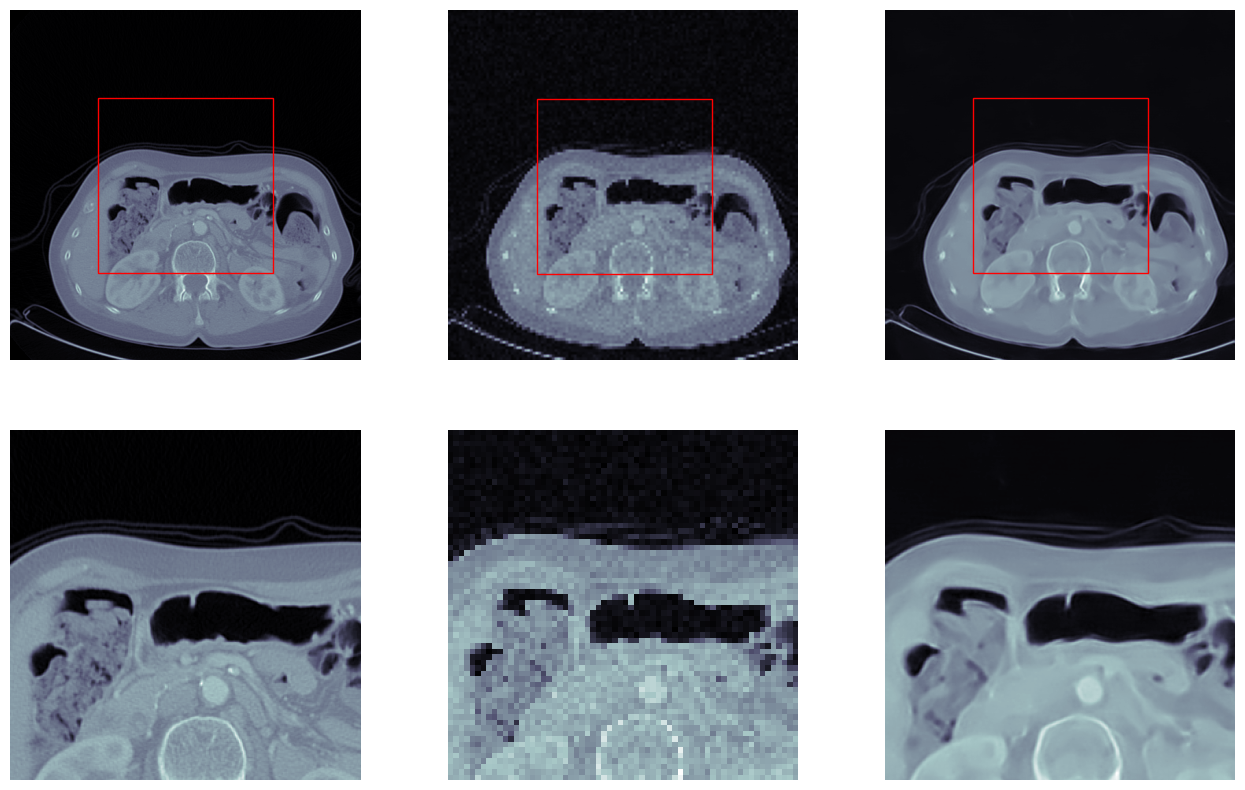

In [ ]:
print(psnr)
print(ssim)
fig, axess = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16, 10)
axess[0][0].imshow(labels, plt.cm.bone)
axess[0][0].set_axis_off()
axess[0][0].add_patch(Rectangle((128, 128), 256, 256, linewidth=1,edgecolor='r',facecolor='none'))
axess[0][1].imshow(inputs, plt.cm.bone)
axess[0][1].set_axis_off()
axess[0][1].add_patch(Rectangle((32, 32), 64, 64, linewidth=1,edgecolor='r',facecolor='none'))
axess[0][2].imshow(preds, plt.cm.bone)
axess[0][2].set_axis_off()
axess[0][2].add_patch(Rectangle((128, 128), 256, 256, linewidth=1,edgecolor='r',facecolor='none'))
axess[1][0].imshow(labels[128:384, 128:384], plt.cm.bone)
axess[1][0].set_axis_off()
axess[1][1].imshow(inputs[32:96, 32:96], plt.cm.bone)
axess[1][1].set_axis_off()
axess[1][2].imshow(preds[128:384, 128:384], plt.cm.bone)
axess[1][2].set_axis_off()
plt.savefig('example.png', facecolor='white', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

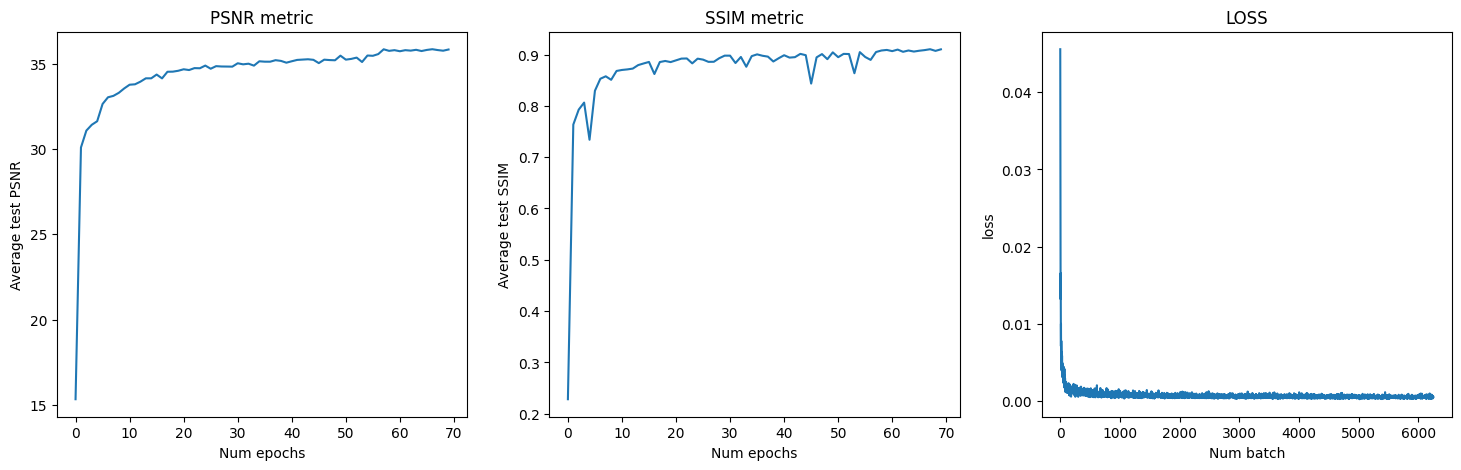

In [ ]:
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 5)
ax1.plot(eval_psnr_byepoch)
ax1.set_title('PSNR metric')
ax1.set_xlabel('Num epochs')
ax1.set_ylabel('Average test PSNR')
ax2.plot(eval_ssim_byepoch)
ax2.set_title('SSIM metric')
ax2.set_xlabel('Num epochs')
ax2.set_ylabel('Average test SSIM')
ax3.plot(batch_losses)
ax3.set_title('LOSS')
ax3.set_xlabel('Num batch')
ax3.set_ylabel('loss')
plt.savefig('plots.png', facecolor='white', bbox_inches='tight')
plt.show()